# 1. Import Libraries
Import all necessary Python libraries for data analysis, visualization, and modeling.

In [3]:

# 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Display plots inline (for Jupyter/Colab)
%matplotlib inline

# 2. Load Dataset  
Import the video game sales dataset from Kaggle and display the first few rows to get an overview of the data.

In [30]:
# 2. Load Dataset

df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

# Display first few rows
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Initial Inspection  
Check the data types of each column and see how many missing values are in the dataset.

In [6]:
# 3. Initial Inspection
# Check data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64


# 4. Data Cleaning  
Clean the dataset by removing missing key values and filling others. Fix data types and prepare scores for analysis.

In [8]:
# 4. Data Cleaning

# Drop rows missing critical info
df_cleaned = df.dropna(subset=['Name', 'Year_of_Release']).copy()

# Fill categorical columns
df_cleaned['Publisher'] = df_cleaned['Publisher'].fillna('Unknown')
df_cleaned['Developer'] = df_cleaned['Developer'].fillna('Unknown')
df_cleaned['Rating'] = df_cleaned['Rating'].fillna(df_cleaned['Rating'].mode()[0])

# Fix data types
df_cleaned['Year_of_Release'] = df_cleaned['Year_of_Release'].astype(int)

# Handle User_Score
df_cleaned['User_Score'] = pd.to_numeric(df_cleaned['User_Score'], errors='coerce')
df_cleaned['User_Score'] = df_cleaned['User_Score'].fillna(df_cleaned['User_Score'].median())

# Handle Critic_Score
df_cleaned['Critic_Score'] = df_cleaned['Critic_Score'].fillna(df_cleaned['Critic_Score'].median())

# OPTIONAL: check correlation with Global_Sales to spot high-leak features
corrs = df_cleaned.corr(numeric_only=True)['Global_Sales'].sort_values(ascending=False)
print("Correlation with Global_Sales:\n", corrs)

Correlation with Global_Sales:
 Global_Sales       1.000000
NA_Sales           0.941235
EU_Sales           0.901671
Other_Sales        0.748912
JP_Sales           0.613316
Critic_Count       0.304859
User_Count         0.266082
Critic_Score       0.189677
User_Score         0.048666
Year_of_Release   -0.076340
Name: Global_Sales, dtype: float64


This shows how strongly each numeric variable is related to global sales. NA_Sales and EU_Sales have the highest correlation with Global_Sales.



# 5. Data Overview After Cleaning  
Compare the number of rows before and after cleaning to see how many records were removed.

In [9]:
# Show number of rows before cleaning
rows_before = df.shape[0]

# cleaned version
rows_after = df_cleaned.shape[0]

# Print the result
print(f"Rows before cleaning: {rows_before}")
print(f"Rows after cleaning:  {rows_after}")
print(f"Rows removed:         {rows_before - rows_after}")

Rows before cleaning: 16719
Rows after cleaning:  16448
Rows removed:         271


# 6. Feature Engineering  
Create new variables to help with analysis, such as years since release, sales per year, and average rating.

In [31]:
# Feature Engineering

# Years since release
df_cleaned['Years_Since_Release'] = 2016 - df_cleaned['Year_of_Release']
df_cleaned['Sales_Per_Year'] = df_cleaned['Global_Sales'] / df_cleaned['Years_Since_Release']

# Average rating
df_cleaned['Average_Rating'] = (df_cleaned['Critic_Score'] + df_cleaned['User_Score']) / 2

# 7. Exploratory Data Analysis (EDA)  
Visualize key insights like top platforms, sales by region, score comparison, and genre popularity over time.

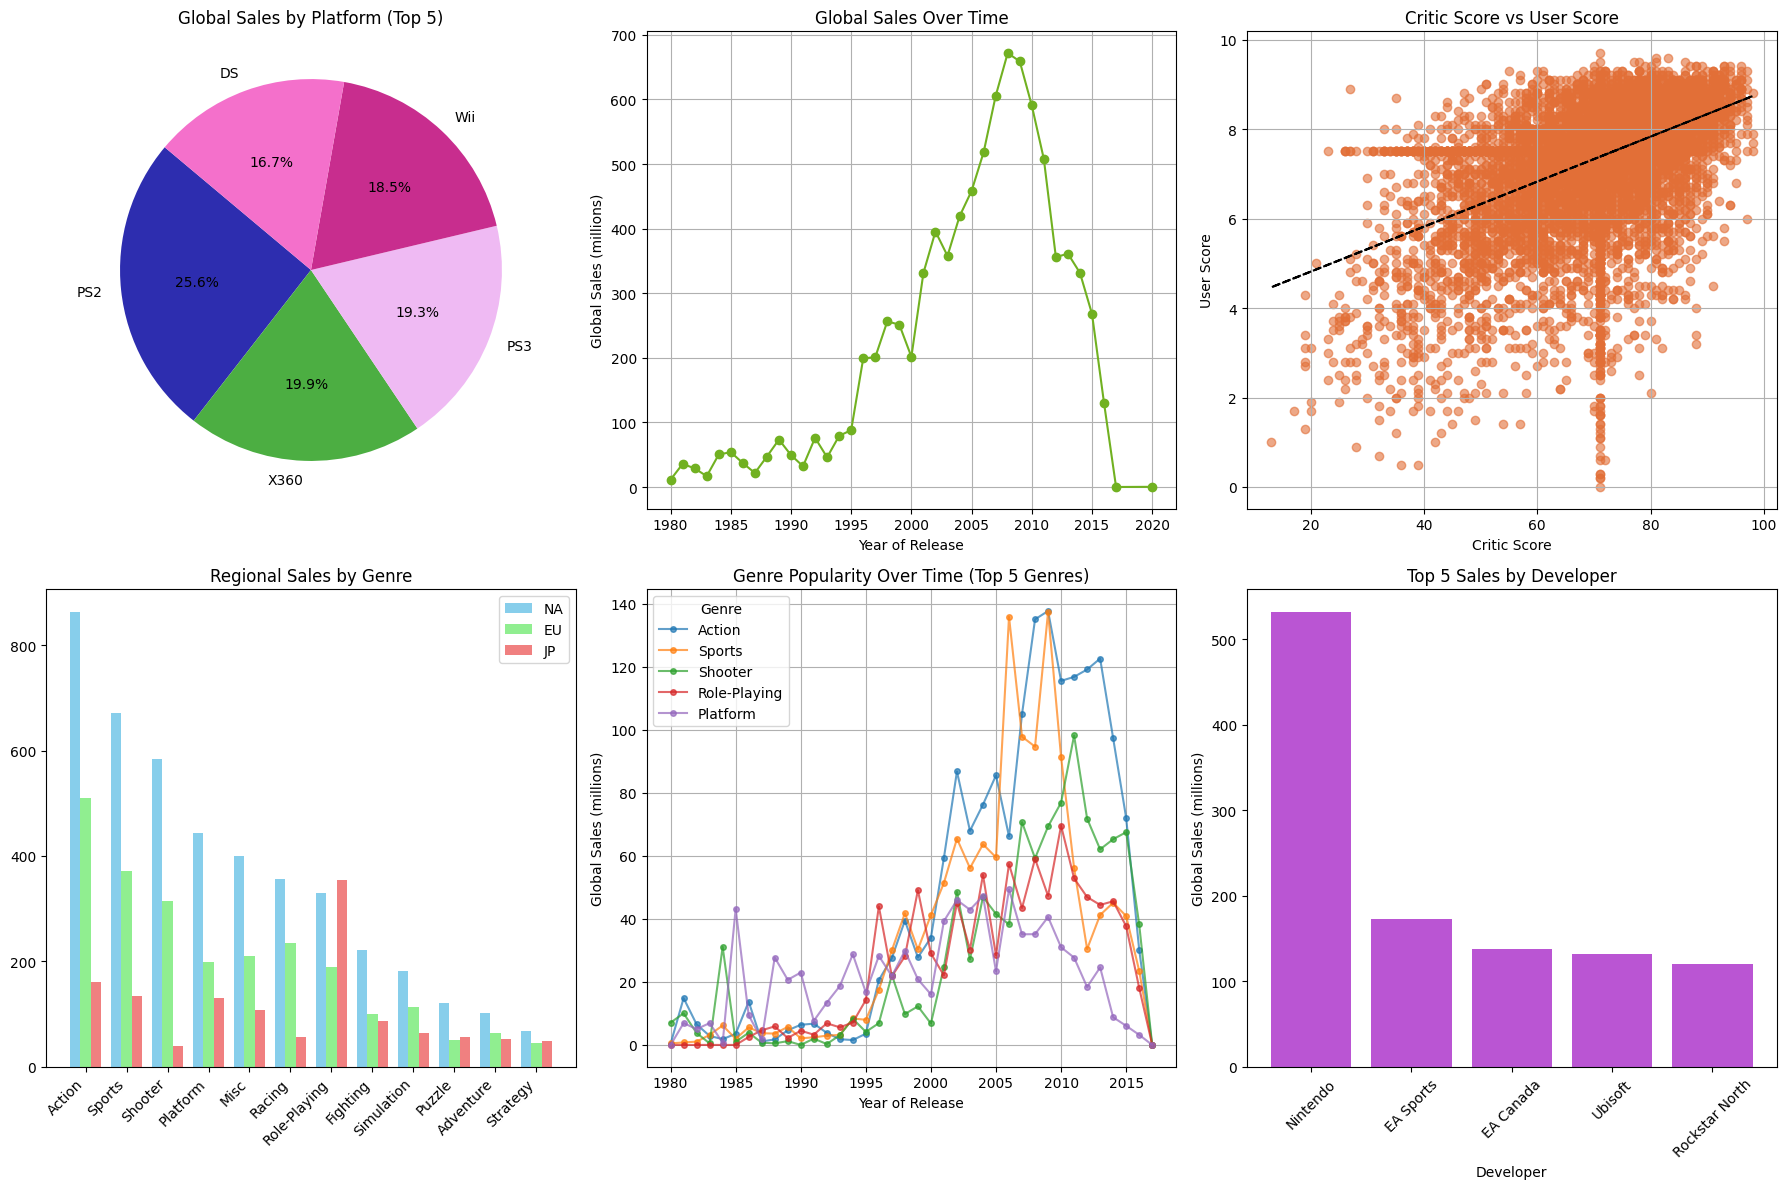

In [35]:
# Exploratory Data Analysis (EDA)
import random

# Function to generate random colors
def random_color():
    return (random.random(), random.random(), random.random())

# Set up figure for 6 visuals (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# 1. Global Sales by Platform (Top 5)
platform_sales = df_cleaned.groupby("Platform")["Global_Sales"].sum().sort_values(ascending=False).head(5)
axs[0].pie(platform_sales, labels=platform_sales.index, autopct='%1.1f%%', startangle=140, colors=[random_color() for _ in range(5)])
axs[0].set_title("Global Sales by Platform (Top 5)")

# 2. Global Sales Over Time
yearly_sales = df_cleaned.groupby("Year_of_Release")["Global_Sales"].sum()
axs[1].plot(yearly_sales.index, yearly_sales.values, marker='o', color=random_color())
axs[1].set_title("Global Sales Over Time")
axs[1].set_xlabel("Year of Release")
axs[1].set_ylabel("Global Sales (millions)")
axs[1].grid(True)

# 3. Critic Score vs User Score
df_scores = df_cleaned[df_cleaned['Critic_Score'].notna() & df_cleaned['User_Score'].notna()]
axs[2].scatter(df_scores['Critic_Score'], df_scores['User_Score'], alpha=0.6, color=random_color())
slope, intercept = np.polyfit(df_scores['Critic_Score'], df_scores['User_Score'], 1)
axs[2].plot(df_scores['Critic_Score'], slope * df_scores['Critic_Score'] + intercept, color='black', linestyle='--')
axs[2].set_title("Critic Score vs User Score")
axs[2].set_xlabel("Critic Score")
axs[2].set_ylabel("User Score")
axs[2].grid(True)

# 4. Regional Sales by Genre
region_sales = df_cleaned.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum().sort_values(by='NA_Sales', ascending=False)
genres = region_sales.index
x = np.arange(len(genres))
width = 0.25
axs[3].bar(x - width, region_sales['NA_Sales'], width=width, label='NA', color='skyblue')
axs[3].bar(x, region_sales['EU_Sales'], width=width, label='EU', color='lightgreen')
axs[3].bar(x + width, region_sales['JP_Sales'], width=width, label='JP', color='lightcoral')
axs[3].set_title("Regional Sales by Genre")
axs[3].set_xticks(x)
axs[3].set_xticklabels(genres, rotation=45, ha='right')
axs[3].legend()

# 5. Genre Popularity Over Time
top_5_genres = df_cleaned.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(5).index
genre_popularity = df_cleaned[df_cleaned['Genre'].isin(top_5_genres)]
genre_popularity = genre_popularity.groupby(['Year_of_Release', 'Genre'])['Global_Sales'].sum().unstack().fillna(0)
genre_popularity[top_5_genres].plot(ax=axs[4], kind='line', marker='o', linestyle='-', markersize=4, alpha=0.7)
axs[4].set_title("Genre Popularity Over Time (Top 5 Genres)")
axs[4].set_xlabel("Year of Release")
axs[4].set_ylabel("Global Sales (millions)")
axs[4].grid(True)

# 6. Top 5 Sales by Developer
# Exclude 'Unknown' developers
df_known_devs = df_cleaned[df_cleaned["Developer"] != "Unknown"]

# Get top 5 developers by global sales
developer_sales = df_known_devs.groupby("Developer")["Global_Sales"].sum().sort_values(ascending=False).head(5)

# Plotting
axs[5].bar(developer_sales.index, developer_sales.values, color='mediumorchid')
axs[5].set_title("Top 5 Sales by Developer")
axs[5].set_xlabel("Developer")
axs[5].set_ylabel("Global Sales (millions)")
axs[5].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Correlation Matrix  
Show how strongly each numeric variable is related to others, especially global sales.

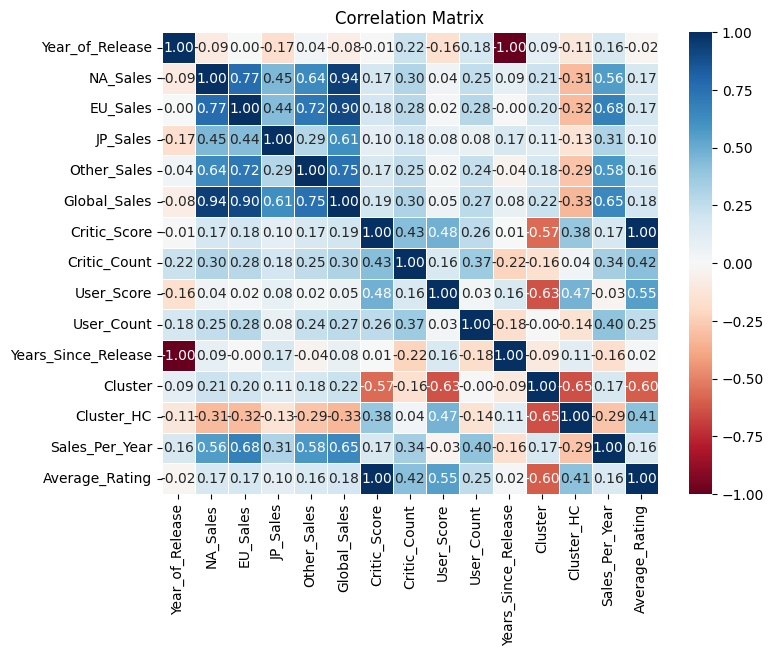

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_cleaned.corr(numeric_only=True), cmap="RdBu", annot=True, center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 8. Summary Statistics  
Show descriptive statistics (mean, std, min, max, etc.) for all numeric columns after cleaning.

This table provides a quick overview of the numeric features in the dataset, including sales, scores, and year-related values.

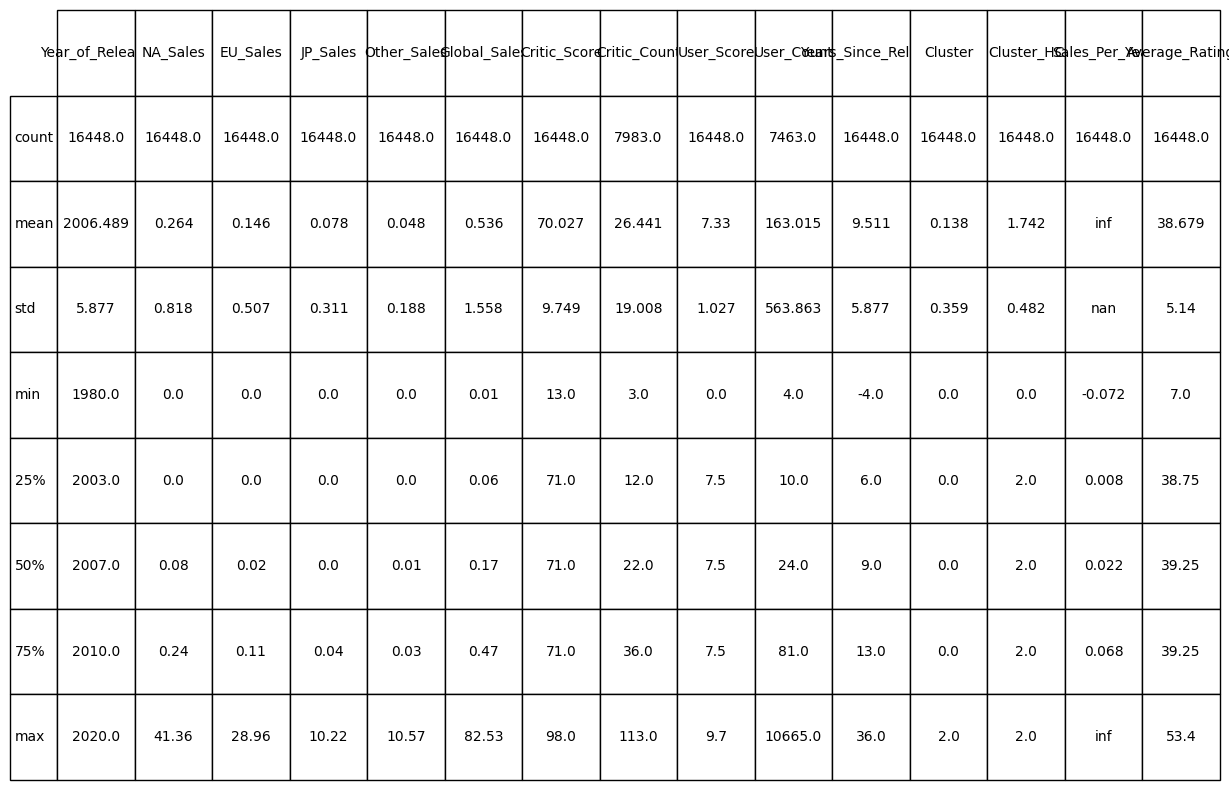

In [37]:
# Summary Statistics Table
summary_stats = df_cleaned.describe().round(3)

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('off')
table = ax.table(cellText=summary_stats.values,
                 colLabels=summary_stats.columns,
                 rowLabels=summary_stats.index,
                 loc='center',
                 cellLoc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.savefig('summary_statistics_table.png', bbox_inches='tight', dpi=300)
plt.show()

# 9. Prepare for Modeling (Encoding)  
Convert categorical columns (Genre, Platform, Rating) into numeric format using one-hot encoding.

In [38]:
# Prepare for Modeling (Encoding)

df_encoded = pd.get_dummies(df_cleaned, columns=['Genre', 'Platform', 'Rating'], drop_first=True)
df_encoded.head()

,Name,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,...,Platform_X360,Platform_XB,Platform_XOne,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,2006,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,...,False,False,False,True,False,False,False,False,False,False
1,Super Mario Bros.,1985,Nintendo,29.08,3.58,6.81,0.77,40.24,71.0,NaN,...,False,False,False,True,False,False,False,False,False,False
2,Mario Kart Wii,2008,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,...,False,False,False,True,False,False,False,False,False,False
3,Wii Sports Resort,2009,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,...,False,False,False,True,False,False,False,False,False,False
4,Pokemon Red/Pokemon Blue,1996,Nintendo,11.27,8.89,10.22,1.00,31.37,71.0,NaN,...,False,False,False,True,False,False,False,False,False,False


# 10. Finalize Data for Modeling  
Remove columns that could give away the answer (such as sales per year) then turn text columns into numbers using encoding.

In [39]:
# First: Drop leaked columns before encoding
df_cleaned = df_cleaned.drop(columns=['Sales_Per_Year', 'Average_Rating'])

# Then encode
df_encoded = pd.get_dummies(df_cleaned, columns=['Genre', 'Platform', 'Rating'], drop_first=True)

# 11. Train/Test Split  
Split the data into training and testing sets to prepare for modeling. Also check for missing values.

In [40]:
#Train/Test Split

# Define features and target
X = df_encoded.drop(columns=['Global_Sales', 'Name', 'Publisher', 'Developer'])
y = df_encoded['Global_Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fill missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Confirm shape and NaNs
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())

Training set shape: (13158, 60)
Testing set shape: (3290, 60)
Missing values in X_train: 0
Missing values in X_test: 0


# 12. Clean Up Infinite and Missing Values  
Fix any infinite values by turning them into NaN then fill missing numbers with 0 so the models can run smoothly.

In [17]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Replace inf/-inf with NaN in numeric columns only
X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan)
X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaNs with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Double check
print("Any inf in X_train:", np.isinf(X_train[numeric_cols].to_numpy()).sum())

Any inf in X_train: 0


# Modeling part

# 13. Lasso Regression for Feature Selection  
Train a Lasso regression model to identify which features are most important for predicting global sales.

In [41]:
from sklearn.linear_model import Lasso

# Set up the Lasso regression model
lasso = Lasso(alpha=0.1)

# Train the model
lasso.fit(X_train, y_train)

# Get the coefficients for each feature
feature_importances = lasso.coef_

# Put them into a DataFrame to see more easily
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by how important they are
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Keep only the features with importance greater than 0
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].tolist()
print(f"Selected features: {selected_features}")


                Feature  Importance
1              NA_Sales    1.213866
2              EU_Sales    0.743820
5          Critic_Score    0.003199
6          Critic_Count    0.001161
9   Years_Since_Release    0.000585
8            User_Count    0.000113
7            User_Score    0.000000
3              JP_Sales    0.000000
10              Cluster    0.000000
4           Other_Sales    0.000000
11           Cluster_HC   -0.000000
12      Genre_Adventure   -0.000000
20     Genre_Simulation    0.000000
13       Genre_Fighting    0.000000
14           Genre_Misc   -0.000000
15       Genre_Platform    0.000000
16         Genre_Puzzle    0.000000
17         Genre_Racing   -0.000000
18   Genre_Role-Playing    0.000000
19        Genre_Shooter   -0.000000
24         Platform_3DS    0.000000
21         Genre_Sports   -0.000000
22       Genre_Strategy   -0.000000
23         Platform_3DO   -0.000000
26          Platform_DS    0.000000
25          Platform_DC    0.000000
27          Platform_GB    0

Lasso picked 6 features that help predict global sales the most. All others had zero importance.

# 14. Linear Regression with Feature Selection (RFECV)  
This model automatically picked the best features using cross-validation and then trained a linear regression model.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set up base linear regression model
lr = LinearRegression()

# Use 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use recursive feature elimination with cross-validation
rfecv = RFECV(estimator=lr, step=1, cv=cv, scoring='r2')
rfecv.fit(X_train, y_train)

# Get selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Train and predict
lr.fit(X_train_selected, y_train)
y_pred_lr = lr.predict(X_test_selected)

# Show results
print("Linear Regression Results with RFECV:")
print(f"Selected {rfecv.n_features_} features: {list(X_train.columns[rfecv.support_])}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.3f}")
print(f"R²:   {r2_score(y_test, y_pred_lr):.3f}")

Linear Regression Results with RFECV:
Selected 19 features: ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Genre_Puzzle', 'Genre_Role-Playing', 'Platform_GBA', 'Platform_GC', 'Platform_GEN', 'Platform_N64', 'Platform_PC', 'Platform_XB', 'Platform_XOne', 'Rating_E', 'Rating_E10+', 'Rating_EC', 'Rating_K-A', 'Rating_M', 'Rating_T']
MAE:  0.003
RMSE: 0.005
R²:   1.000


# 15. VIF Check for Multicollinearity  
Define a function to check and remove features that are too similar to others (high multicollinearity).

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(X, thresh=5.0):
    X = X.copy()
    dropped = True
    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(add_constant(X).values, i+1) for i in range(X.shape[1])]

        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            drop_feature = vif.sort_values("VIF", ascending=False)["feature"].iloc[0]
            print(f"Dropping '{drop_feature}' with VIF = {max_vif:.2f}")
            X.drop(columns=[drop_feature], inplace=True)
            dropped = True
    return X


# 16. Decision Tree Regression  
Train a decision tree model to predict global sales and see how well it performs.
The model explained about 84% of the sales patterns. It wasn’t as accurate as linear regression but was easier to understand.

In [21]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Results:")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_dt):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt)):.3f}")
print(f"R²:   {r2_score(y_test, y_pred_dt):.3f}")

Decision Tree Results:
MAE:  0.161
RMSE: 0.811
R²:   0.844


## 17. Feature Importance (Decision Tree)  
Visualize the top 10 most important features used by the decision tree model.

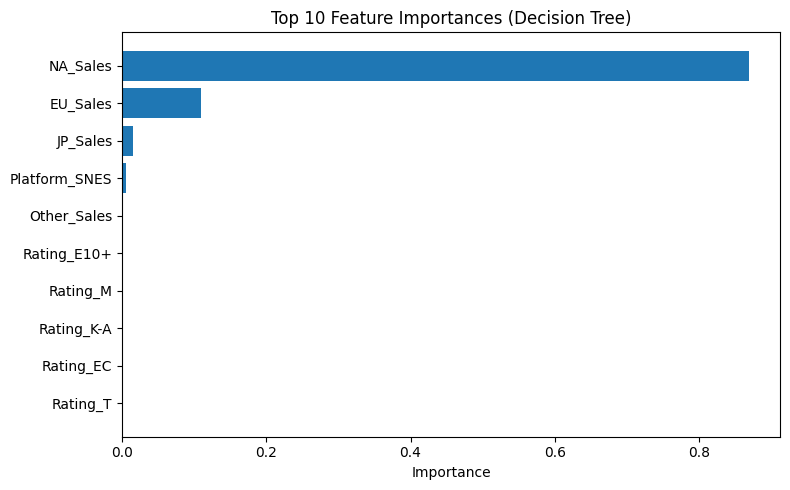

In [22]:
# Plot feature importance
importances = dt.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]  # top 10
plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.tight_layout()
plt.show()

NA_Sales and EU_Sales were the most important features for predicting global sales based on the decision tree model.

# 18. K-Means Clustering  
Group games into 3 clusters based on global sales, critic scores, and user scores.

Games per cluster:
 Cluster
0    14249
1     2120
2       79
Name: count, dtype: int64


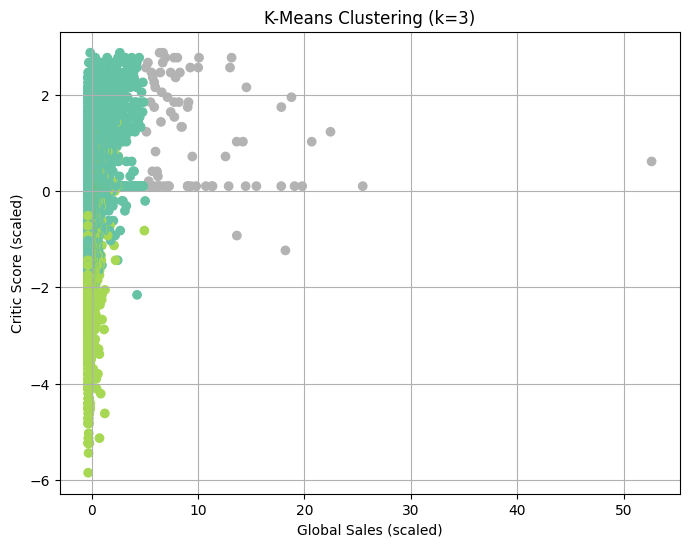

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Use a few numeric columns only for clustering
cluster_cols = ['Global_Sales', 'Critic_Score', 'User_Score']
cluster_data = df_cleaned[cluster_cols].copy()

# Scale data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cleaned['Cluster'] = kmeans.fit_predict(cluster_scaled)

# Show distribution
print("Games per cluster:\n", df_cleaned['Cluster'].value_counts())

# Optional: 2D cluster plot
plt.figure(figsize=(8, 6))
plt.scatter(cluster_scaled[:, 0], cluster_scaled[:, 1], c=df_cleaned['Cluster'], cmap='Set2')
plt.xlabel('Global Sales (scaled)')
plt.ylabel('Critic Score (scaled)')
plt.title('K-Means Clustering (k=3)')
plt.grid(True)
plt.show()

Most games are in Cluster 0. The plot shows how they were grouped based on sales and critic scores.

# 19. Hierarchical Clustering  
Group similar games based on sales and scores using a step-by-step clustering method. Show the clusters and a tree diagram (dendrogram) of how they were formed.


Games per cluster (Hierarchical Clustering):
 Cluster_HC
2    12535
1     3575
0      338
Name: count, dtype: int64


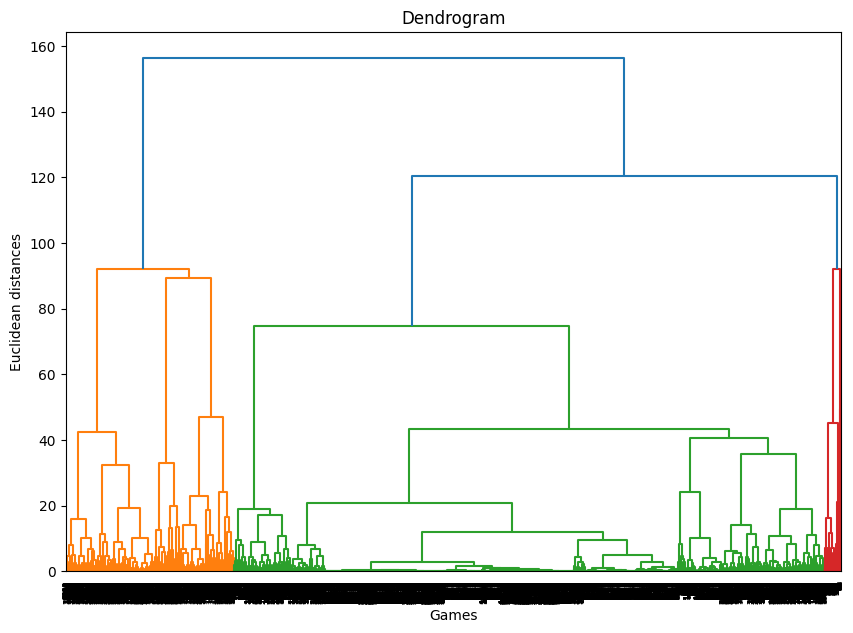

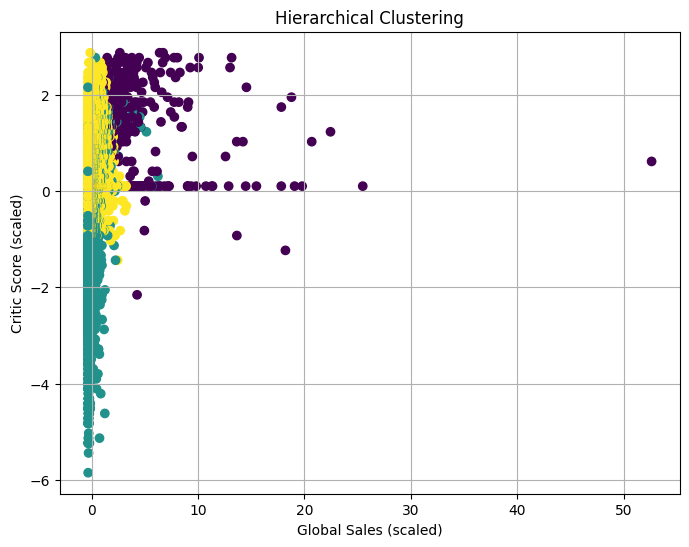

In [27]:
# prompt: hierarchical clustering

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Assuming df_cleaned from the previous code is available

# Use a few numeric columns only for clustering
cluster_cols = ['Global_Sales', 'Critic_Score', 'User_Score']
cluster_data = df_cleaned[cluster_cols].copy()

# Scale data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Hierarchical Clustering
n_clusters = 3  # You can adjust this
df_cleaned['Cluster_HC'] = hc.fit_predict(cluster_scaled)


# Show distribution
print("Games per cluster (Hierarchical Clustering):\n", df_cleaned['Cluster_HC'].value_counts())

# Dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(cluster_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Games')
plt.ylabel('Euclidean distances')
plt.show()

# Optional: 2D cluster plot
plt.figure(figsize=(8, 6))
plt.scatter(cluster_scaled[:, 0], cluster_scaled[:, 1], c=df_cleaned['Cluster_HC'], cmap='viridis')
plt.xlabel('Global Sales (scaled)')
plt.ylabel('Critic Score (scaled)')
plt.title('Hierarchical Clustering')
plt.grid(True)
plt.show()


Most games ended up in Cluster 2. The dendrogram shows how the groups were built by merging similar games.

# 20. Final Model Comparison  
Compare the accuracy of the linear regression and decision tree models using standard evaluation metrics.

In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compare model performance using MAE, RMSE, and R²
summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_dt)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_dt))
    ],
    'R²': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_dt)
    ]
})

summary = summary.round(4)
summary

,Model,MAE,RMSE,R²
0,Linear Regression,0.0029,0.0052,1.0000
1,Decision Tree,0.1606,0.8114,0.8438


Linear regression had the lowest error but might be overfitting. The decision tree had lower R² but is easier to interpret.

# 21. Conclusion  
This project looked at what makes a video game successful by using data on sales, ratings, and other game features. After cleaning the data and making charts, two models were tested:

- **Linear Regression** gave very accurate results but might be too perfect to trust fully.
- **Decision Tree** was easier to understand and showed which features mattered most.

Games were also grouped into clusters based on their sales and ratings. This could help companies find patterns in the market.  
Overall, sales in North America and Europe, along with critic scores, were the most useful features in predicting how well a game sold.